In [24]:
import os
import sys
import utils
import random
import dataset
import binvox_rw
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tfe.enable_eager_execution()

In [ ]:
# load data
shapenet=dataset.ShapeNet()
# shapenet.batch_size=3

# with tf.name_scope('input'):
x=tf.placeholder(tf.float32,[shapenet.batch_size,137,137,3])
y=tf.placeholder(tf.float32,[shapenet.batch_size,32,32,32])

In [ ]:
# encoder network
cur_tensor=x
encoder_outputs=[x]
print(cur_tensor.shape)

k_s = [3,3]
conv_filter_count = [96, 128, 256, 256, 256, 256]
for i in range(6): 
    ks=[7,7]if i is 0 else k_s  
    # with tf.name_scope("encoding_block"):
    cur_tensor=tf.layers.conv2d(cur_tensor,filters=conv_filter_count[i],padding='SAME',kernel_size= k_s,activation=None)
    cur_tensor=tf.layers.max_pooling2d(cur_tensor,2,2)
    cur_tensor=tf.nn.relu(cur_tensor)
    print(cur_tensor.shape)
    encoder_outputs.append(cur_tensor)

# flatten tensor
cur_tensor=tf.contrib.layers.flatten(cur_tensor)
cur_tensor=tf.contrib.layers.fully_connected(cur_tensor,1024,activation_fn=None)
print(cur_tensor.shape)
encoder_outputs.append(cur_tensor)

In [ ]:
# 3D_Convolutional_LSTM 
cur_tensor=encoder_outputs[-1]
# with tf.name_scope("3D_LSTM"):
h_t=tf.Variable(tf.zeros([4,4,4,1,256]),name="hidden_state")
s_t=tf.Variable(tf.zeros([4,4,4,1,256]),name="cell_state")

# W,U,b for f,i,s,o
W=[tf.Variable(tf.zeros([1024,256]),name="W%d"%(i)) for i in range(4)]
U=[tf.Variable(tf.zeros([3,3,3,256,256]),name="U%d"%(i)) for i in range(4)]
b=[tf.Variable(tf.zeros([1,256]),name="b%d"%(i)) for i in range(4)]

Wx=[tf.matmul(cur_tensor, W[i]) for i in range(4)]
Uh=[tf.nn.convolution(h_t,U[i],padding="SAME") for i in range(4)]


f_t=tf.sigmoid(Wx[0] + Uh[0] + b[0])
i_t=tf.sigmoid(Wx[1] + Uh[1] + b[1])
o_t=tf.sigmoid(Wx[2]+ Uh[2] + b[2])
s_t=tf.multiply(f_t,s_t) + tf.multiply(i_t,tf.tanh(Wx[3]+ Uh[3] + b[3]))
h_t=tf.tanh(s_t)

cur_tensor=tf.transpose(h_t,[3,0,1,2,4])
print(cur_tensor.shape)

In [ ]:
# decoding network
# batch_size=cur_tensor.shape.as_list()[0]
# cur_tensor=tf.reshape(cur_tensor,[batch_size,2,2,2,-1])
# print(cur_tensor.shape)

decoder_outputs=[]
cur_tensor=utils.unpool(cur_tensor)
print(cur_tensor.shape)
decoder_outputs.append(cur_tensor)

k_s = [3,3,3]
deconv_filter_count = [128, 128, 128, 64, 32, 2]
for i in range(2,4): 
    # with tf.name_scope("decoding_block"):
    cur_tensor=tf.layers.conv3d_transpose(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
    cur_tensor=utils.unpool(cur_tensor)
    cur_tensor=tf.nn.relu(cur_tensor)
    print(cur_tensor.shape)
    decoder_outputs.append(cur_tensor)
            
for i in range(4,6): 
    # with tf.name_scope("decoding_block_without_unpooling"):
    cur_tensor=tf.layers.conv3d_transpose(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
    cur_tensor=tf.nn.relu(cur_tensor)
    print(cur_tensor.shape)
    decoder_outputs.append(cur_tensor)

In [ ]:
#3d voxel-wise softmax
y_hat=tf.nn.softmax(decoder_outputs[-1])
p=y_hat[:,:,:,:,0]
q=y_hat[:,:,:,:,1]
cross_entropies=tf.reduce_sum(-tf.multiply(tf.log(p),y)-tf.multiply(tf.log(q),1-y),[1,2,3])
loss_voxel=tf.reduce_mean(cross_entropies)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_voxel)

sess=tf.Session()

In [7]:
# setup training
root_train_dir = "train_dir"
cur_time = str(datetime.now()).translate({ord(" "): "_"})
train_dir=os.path.join(root_train_dir,cur_time)
saver = tf.train.Saver()
init=tf.global_variables_initializer()
sess.run(init)

In [8]:
train=shapenet.next_train_batch()
train_X=dataset.load_dataset(train[:,0])
train_Y=dataset.load_labels(train[:,1])
fd={x:train_X, y: train_Y};

(68, 612)


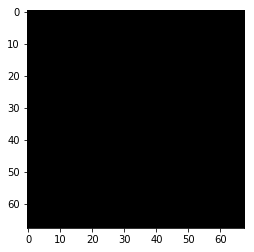

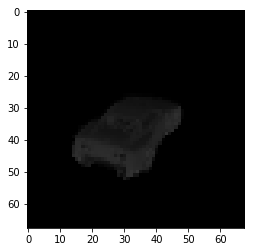

In [27]:
%matplotlib inline
im_3d=encoder_outputs[1].eval(session=sess,feed_dict=fd)[0]
im_2d=utils.imshow_multichannel(im_3d)
im_2d=im_2d[0]
im_2d=im_2d
print(im_2d.shape)

i=2
plt.imshow(Image.fromarray(im_2d[:,i*68:(i+1)*68]))
plt.figure()
plt.imshow(Image.fromarray(im_3d[:,:,2]))



In [ ]:
# train network
loss=[]
epoch=5
for e in range(epoch):     
    batch_number=0
    train=shapenet.next_train_batch()
    while(train is not None):
        iter_dir="{}/epoch_{:03d}/batch_{:03d}".format(train_dir,e,batch_number)    
        os.makedirs(iter_dir)
        
        train_X=dataset.load_dataset(train[:,0])
        train_Y=dataset.load_labels(train[:,1])
        fd={x:train_X, y: train_Y};
        l=sess.run([loss_voxel],feed_dict=fd)
        loss.append(l[0]) 
        print("{}: loss={}".format(iter_dir,loss[-1]))
        
        # record parameters and generate plots
        fig = plt.figure()
        plt.plot(loss)
        plt.savefig("{}/loss.png".format(iter_dir),bbox_inches='tight')
        saver.save(sess,"{}/model.ckpt".format(iter_dir))
        plt.close()
        # update
        train=shapenet.next_train_batch()
        batch_number+=1

In [ ]:
im.shape

In [ ]:
# tensorboard
writer = tf.summary.FileWriter("./logs/")
writer.add_graph(sess.graph)

In [ ]:
# model output as a voxelized image
out=tf.cast(tf.argmax(y_hat,axis=4),dtype=tf.float32)
out=sess.run(out,feed_dict=feed_dict)
outvoxel=binvox_rw.Voxels(out,out.shape,[0,0,0],1,'xzy')
with open("out/{i}.binvox",'w') as f:
    outvoxel.write(f)